# Table of Contents
<details open>

1. [Introduction](#1-introduction)
    - [Business Problem](#business-problem)
    - [Leakage Policy](#leakage-policy)
    - [Data Overview and EDA](#data-overview-and-eda)
2. [Machine Learning](#2-machine-learning)
    - [Data Preparation](#data-preparation)
    - [Simple Baseline Logistic Model](#simple-baseline-logistic-model)
    - [Gradient Boosting Tree](#gradient-boosting-tree)
    - [Random Forest](#random-forest)
3. [Model Recommendation](#3-model-recommendation)
    - [Generate random forest OOF probabilities in csv](#generate-random-forest-oof-probabilities-in-csv)
    - [Ablation table](#ablation-table)
    - [Cost Retention Table](#cost-retention-table)
4. [Holdout Data](#4-holdout-data)
5. [Appendix](#5-appendix)


</details>





# 1. Introduction



### Business Problem

The company working on a subscription business wanting to mitigate the Churning rate of existing customers, thus improve revenue and customer base. 



The leadership at the company is looking into 2 practical questions that Machine Learning could possibly answer:
* A realiable score for active customers that could estimate theor churning chance by the next 
period.
* A simple, budget aware rule that allows intervention to highly likely to churn customers. 


This notebook will goes through the business's available data. Develop a model that will answer the 2 questions above reliably and ship it for holdout data, to test for real world performance. 

### Leakage Policy

Data leakage in our scenario refers to the use of future information that could reveal whether a customer will churn. To prevent this, each record in our dataset captures customer characteristics up to one month before the next billing period begins. This ensures that the model is trained only on past information, simulating a real-world setting where predictions are made one month in advance to allow time for retention interventions. 

The target variable `Churn` is excluded during feature preparation to avoid any contamination. 

Categorical variables were dummy-encoded into Boolean features, and the target variable `Churn` was mapped to binary form (1 = “Yes”, 0 = “No”). These transformations used only existing customer information and do not introduce any data leakage.

Further more, cross-validation and calibration will be introduced for model's unbiased evaluation. 

### Data overview and EDA

In [1]:
# Import libraries and data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import roc_auc_score, roc_auc_score, brier_score_loss, RocCurveDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline 
from sklearn.calibration import CalibrationDisplay

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


data = pd.read_csv('/Users/hungduong/Documents/MSBA UofU/MSBA 4th/MKTG 6620/churn_train.csv')
#data = pd.read_csv(r'C:\Users\dhung\OneDrive\Documents\asking people for job\cody\ML_churn_predict\churn_train.csv')


In [2]:
# Data highview
pd.set_option('display.max_columns', None)
data.head()

,ID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,yrhdgfy_4741,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,yrhdgfy_4154,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,yrhdgfy_5863,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,yrhdgfy_4870,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,yrhdgfy_4813,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No


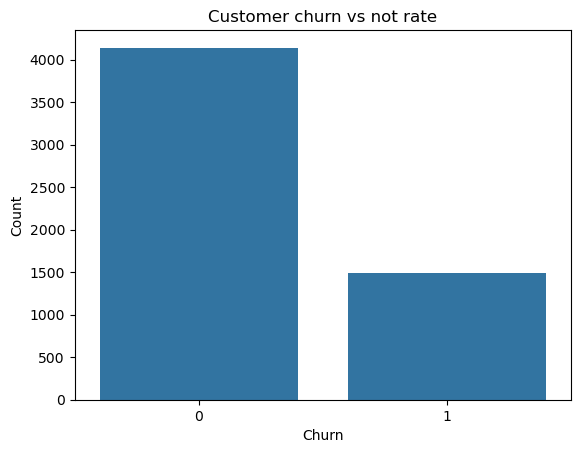

Churn rate is 26.54%


In [3]:
# Looks at Target variable
data['Churn'] = data['Churn'].map({'No':0, 'Yes':1})

sns.countplot(x='Churn', data=data)
plt.title('Customer churn vs not rate')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

#Target rate is imbalance
print(f"Churn rate is {data['Churn'].mean() * 100:.2f}%")


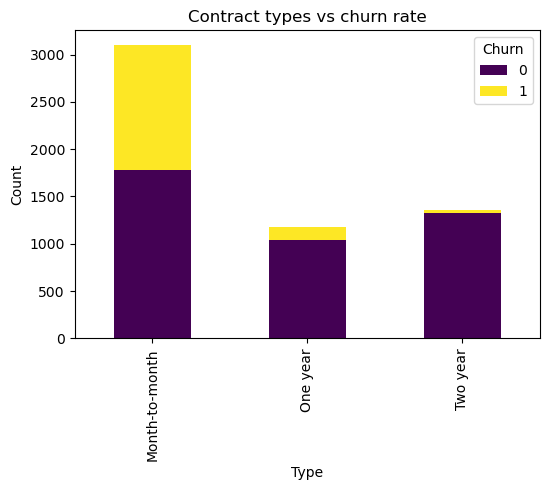

In [4]:
# How do contract type correlate with Churn?
pd.crosstab(data['Contract'], data['Churn']).plot(
    kind='bar',
    stacked=True,
    figsize=(6,4),
    colormap='viridis'
)

plt.title('Contract types vs churn rate')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

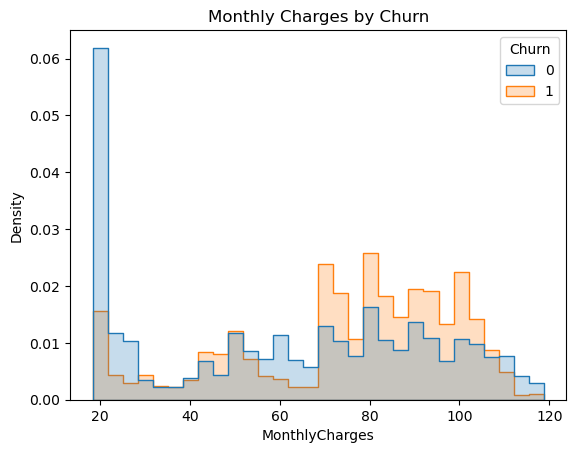

In [5]:
# How do monthly charges influence Churn?
sns.histplot(data=data, x='MonthlyCharges', hue='Churn',
             bins=30, stat='density', common_norm=False, element='step')
plt.title('Monthly Charges by Churn')
plt.xlabel('MonthlyCharges')
plt.ylabel('Density')
plt.show()

This plot is showing that people with low monthly charges tends not to churn, around $20-$40.


However, the group that churn the most seems to be high monthly charges ones noticeably around $70-$110.

# 2. Machine Learning

### Data preparation


In [6]:
# Prepare data for ML
data_ml = data.copy()

# get dummies variable
data_ml = pd.get_dummies(
    data_ml,
    columns=[
        'gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
        'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
        'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
    ],
    drop_first=True  
)

# Fix total charges dtype
data_ml['TotalCharges'] = pd.to_numeric(data_ml['TotalCharges'], errors='coerce').fillna(0)

# Check dtype
data_ml.dtypes

ID                                        object
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int64
gender_Male                                 bool
SeniorCitizen_1                             bool
Partner_Yes                                 bool
Dependents_Yes                              bool
PhoneService_Yes                            bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No inter

In [7]:
# Split data
x = data_ml.drop(columns=['Churn', 'ID'])
y = data_ml['Churn']
cv = StratifiedKFold(5, shuffle=True, random_state=111) 

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

### Simple baseline Logistic Model

In [8]:
# Logistic model with penalty Lasso Ridge
log_pipe = Pipeline([(
    "scaler", StandardScaler()),
    ("logreg", LogisticRegression(penalty='elasticnet', C=1.0,
                                  solver='saga', l1_ratio=0.5,
                                  max_iter=1000,
                                  class_weight='balanced' # handle class imbalance
                                  ))])

log_model_scores = cross_validate(
    log_pipe, x_train, y_train,
    cv=cv,
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'},
    return_train_score=False )

In [9]:
# Result
print(pd.DataFrame(log_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3))

# Discrimination - AUC and Brier Score
log_model_prob = cross_val_predict(log_pipe, x_train, y_train, cv=cv, method='predict_proba')[:, 1]
auc_oof = roc_auc_score(y_train, log_model_prob)
brier_oof = brier_score_loss(y_train, log_model_prob, pos_label=1)
print(f"Discrimination AUC: {auc_oof:.3f}")
print(f"Calibration Brier: {brier_oof:.4f}")

# Feature importance
log_pipe.fit(x_train, y_train)
coef_table = pd.DataFrame({ "Feature": x.columns, "Coefficient": log_pipe.named_steps["logreg"].coef_.flatten() })
pd.set_option('display.max_rows', None)
print(coef_table)

test_roc    0.846
test_acc    0.748
test_f1     0.629
dtype: float64
Discrimination AUC: 0.845
Calibration Brier: 0.1653
                                  Feature  Coefficient
0                                  tenure    -1.210360
1                          MonthlyCharges    -0.355437
2                            TotalCharges     0.530381
3                             gender_Male    -0.033997
4                         SeniorCitizen_1     0.066137
5                             Partner_Yes    -0.009716
6                          Dependents_Yes    -0.115357
7                        PhoneService_Yes    -0.054432
8          MultipleLines_No phone service     0.054432
9                       MultipleLines_Yes     0.168024
10            InternetService_Fiber optic     0.536199
11                     InternetService_No    -0.065694
12     OnlineSecurity_No internet service    -0.065694
13                     OnlineSecurity_Yes    -0.161498
14       OnlineBackup_No internet service    -0.065694


### Gradient Boosting Tree

In [10]:

# Train gbt pipeline
gbt_pipe = Pipeline(steps=[
    ('smote', RandomUnderSampler(random_state=42)), # Undersample for a balance train data
    ('gbt', GradientBoostingClassifier(
        learning_rate=0.08, n_estimators=800, max_depth=3,
        subsample=1.0, max_features='log2', random_state=42
        ))
        ])

gbt_pipe_scores = cross_validate(
    gbt_pipe, x_train, y_train, cv=cv,
    scoring={'roc':'roc_auc', 'acc':'accuracy', 'f1':'f1'},
    return_train_score=True
    )


In [11]:
# Result from CV
print(pd.DataFrame(gbt_pipe_scores)[['test_roc','test_acc','test_f1']].mean().round(3))

# Get Out of fold results
oof_proba = cross_val_predict(
gbt_pipe, x_train, y_train, cv=cv, method='predict_proba')[:, 1]

# Metrics on OOF probs
auc_oof = roc_auc_score(y_train, oof_proba) # discrimination AUC
brier_oof = brier_score_loss(y_train, oof_proba) # calibration
print(f"OOF ROC-AUC: {auc_oof:.3f}")
print(f"OOF Brier : {brier_oof:.4f}")

test_roc    0.824
test_acc    0.733
test_f1     0.607
dtype: float64
OOF ROC-AUC: 0.824
OOF Brier : 0.1807


### Random Forest

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=300,max_depth=10,
    random_state=42,
    class_weight='balanced', # handle class imbalance
    n_jobs=-1)

rf_model_scores = cross_validate(
    rf_model, x_train, y_train, cv=cv,
    scoring={'roc': 'roc_auc', 'acc': 'accuracy', 'f1': 'f1'},
    return_train_score=False)

In [13]:
# Result
print(pd.DataFrame(rf_model_scores)[['test_roc','test_acc','test_f1']].mean().round(3))

# Discrimination - AUC and Brier Score
rf_model_prob = cross_val_predict(rf_model, x_train, y_train, cv=cv, method='predict_proba')[:, 1]
auc_oof_rf = roc_auc_score(y_train, rf_model_prob)
brier_oof_rf = brier_score_loss(y_train, rf_model_prob, pos_label=1)

print(f"Discrimination AUC: {auc_oof_rf:.3f}")
print(f"Calibration Brier: {brier_oof_rf:.4f}")



test_roc    0.843
test_acc    0.779
test_f1     0.626
dtype: float64
Discrimination AUC: 0.843
Calibration Brier: 0.1464


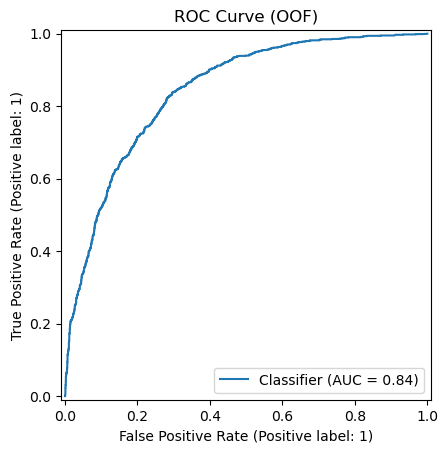

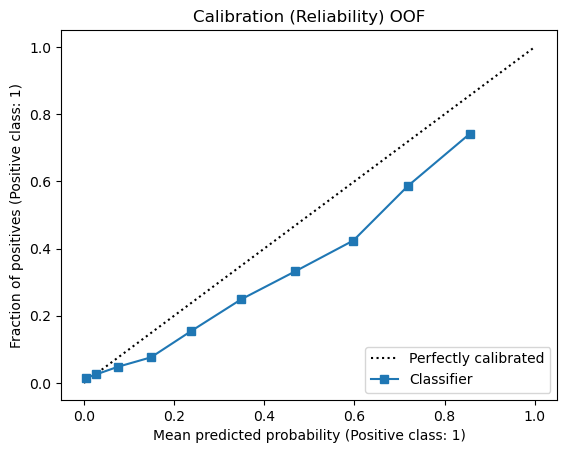

In [14]:
# Plots out of fold ROC
RocCurveDisplay.from_predictions(y_train, rf_model_prob)
plt.savefig("figure.png", dpi=300, bbox_inches="tight")
plt.title("ROC Curve (OOF)"); plt.show()

# Plot out of fold calibration
CalibrationDisplay.from_predictions(y_train, rf_model_prob, n_bins=10, strategy='quantile')
plt.savefig("calibration.png", dpi=300, bbox_inches="tight")
plt.title("Calibration (Reliability) OOF"); plt.show()

# 3. Model Recommendation

| Model                   |  ROC-AUC  |  Accuracy |  F1-Score |   Brier   | Interpretation                                                         |
| ----------------------- | :-------: | :-------: | :-------: | :-------: | :--------------------------------------------------------------------- |
| **Logistic Regression** | **0.845** |   0.748   |   0.629   |   0.1653  | Best raw discrimination (top AUC), slightly less calibrated            |
| **Random Forest**       |   0.843   | **0.779** | **0.626** | **0.1464**| Best overall — balanced accuracy & F1, and most reliable probabilities |
| **Gradient Boosting**   |   0.824   |   0.733   |   0.607   |   0.1807  | Performs close to the others                                           |

With the goal of identifying which customers are most likely to churn, the **Random Forest model** is the optimal choice for both ranking and probability estimation. Its strong ROC-AUC score (0.83) demonstrates that it effectively ranks churners higher than non-churners, enabling the retention team to prioritize outreach efficiently. By sorting customers into deciles based on their predicted churn probability, the team can start with the highest-risk segment and continue outreach in descending order until the budget limit is reached—maximizing the impact of retention efforts.

At the same time, the **low Brier score (0.1464)** highlights that the Random Forest model is well-calibrated, meaning its predicted probabilities closely align with actual churn outcomes. This combination of high discrimination and strong calibration allows the business to not only target the right customers but also **trust the predicted churn likelihoods** when estimating potential losses or evaluating campaign effectiveness. In summary, the Random Forest model provides the most dependable foundation for both **ranking customers by churn risk** and **assigning accurate probability scores** for strategic decision-making.


### Generate random forest OOF probabilities in csv

In [15]:
# Get best model OOF probabilities CSV
oof_df = pd.DataFrame({
    "ID": x_train.index,       
    "Actual_Churn": y_train.values,
    "OOF_p_churn": rf_model_prob
})

# Save to CSV
oof_df.to_csv("oof_predictions.csv", index=False)

### Ablation table

In [16]:
# Full model metrics
oof_full = cross_val_predict(rf_model, x_train, y_train, cv=cv, method='predict_proba')[:, 1]
auc_full = roc_auc_score(y_train, oof_full)
brier_full = brier_score_loss(y_train, oof_full)

# Groups
groups = {
    "Demographics": [
        "gender_Male", "SeniorCitizen_1", "Partner_Yes", "Dependents_Yes"
    ],
    "Core_Access": [
        "PhoneService_Yes", "MultipleLines_No phone service", "MultipleLines_Yes",
        "InternetService_Fiber optic", "InternetService_No"
    ],
    "AddOns_Streaming": [
        "OnlineSecurity_No internet service", "OnlineSecurity_Yes",
        "OnlineBackup_No internet service", "OnlineBackup_Yes",
        "DeviceProtection_No internet service", "DeviceProtection_Yes",
        "TechSupport_No internet service", "TechSupport_Yes",
        "StreamingTV_No internet service", "StreamingTV_Yes",
        "StreamingMovies_No internet service", "StreamingMovies_Yes"
    ],
    "Contracts_Billing": [
        "Contract_One year", "Contract_Two year", "PaperlessBilling_Yes",
        "PaymentMethod_Credit card (automatic)",
        "PaymentMethod_Electronic check", "PaymentMethod_Mailed check",
        "MonthlyCharges", "TotalCharges"
    ]
}

rows = []
for name, cols in groups.items():
    X_drop = x.drop(columns=cols, errors="ignore")
    oof_proba = cross_val_predict(rf_model, X_drop, y, cv=cv, method='predict_proba')[:, 1]
    oof_pred = (oof_proba >= 0.5).astype(int)  # threshold = 0.5

    auc = roc_auc_score(y, oof_proba)
    brier = brier_score_loss(y, oof_proba)
    acc = accuracy_score(y, oof_pred)

    rows.append([name, auc, brier, acc])

# Full model metrics again on entire training set
oof_full = cross_val_predict(rf_model, x, y, cv=cv, method='predict_proba')[:, 1]
oof_pred_full = (oof_full >= 0.5).astype(int)
auc_full = roc_auc_score(y, oof_full)
brier_full = brier_score_loss(y, oof_full)
acc_full = accuracy_score(y, oof_pred_full)

# Make ablation table
ablation = pd.DataFrame(rows, columns=["Removed_Group", "AUC", "Brier", "Accuracy"])
ablation["Delta AUC"] = ablation["AUC"] - auc_full
ablation["Delta Brier"] = ablation["Brier"] - brier_full
ablation["Delta Accuracy"] = ablation["Accuracy"] - acc_full

full = pd.DataFrame(
    [["Full Model", auc_full, brier_full, acc_full, 0, 0, 0]],
    columns=ablation.columns
)

ablation_table = pd.concat([full, ablation], ignore_index=True)
print(ablation_table.round(4))


       Removed_Group     AUC   Brier  Accuracy  Delta AUC  Delta Brier  \
0         Full Model  0.8435  0.1478    0.7808     0.0000       0.0000   
1       Demographics  0.8447  0.1477    0.7801     0.0011      -0.0001   
2        Core_Access  0.8422  0.1486    0.7819    -0.0014       0.0008   
3   AddOns_Streaming  0.8401  0.1490    0.7808    -0.0034       0.0012   
4  Contracts_Billing  0.8264  0.1568    0.7657    -0.0171       0.0089   

   Delta Accuracy  
0          0.0000  
1         -0.0007  
2          0.0011  
3          0.0000  
4         -0.0151  


The most important groups are - in order: 
* Contracts_Billing: Due to largest drop in Delta AUC (-0.0171), Delta Brier (0.0089) and accuracy (-0.0151)
* AddOns_Streaming
* Core_Access
* Demographics: Have the smallest drop in predictability of the Gradient Boosted Tree model, with Delta AUC increase (0.0011), Delata Brier (-0.0001) and Delta Accuracy (-0.0007)

The only excluding group that might improve model performance is the Demographics group; with the increase of Delta AUC 0.0011.

### Cost retention table


Using the Random Forest model, I first fit the training data to predict churn probabilities on the test set. The predicted probabilities are then ranked into deciles, where a higher probability corresponds to a higher churn risk. Based on these rankings, intervention batches are applied starting with the **1st decile**-the group most likely to churn-and continuing as budget allows. 

Each customer in the top decile is evaluated to see whether they actually churned; a **save rate** is applied everyone to represent the probability that an intervention would successfully retain them. The **cost per contact** represent the effort regardless per person in that specific deciles, regradless if it was wasted on a no-churn customer. 

The resulting revenue from successful saves is then calculated. Finally, a **cost-benefit analysis** is performed to determine the net financial impact of the intervention strategy.


In [17]:
# Train and predict
rf_model.fit(x_train, y_train)
prob_test = rf_model.predict_proba(x_test)[:, 1]

# Combine predictions with churn labels
results = pd.DataFrame({
    "Customer index": x_test.index,     
    "Predicted_Prob": prob_test,
    "Churn": y_test.values
})

# Rank customers by predicted probability 
results = results.sort_values(by="Predicted_Prob", ascending=False).reset_index(drop=True)
results["Rank"] = results.index + 1

# Create 10 deciles (1 = lowest churn risk, 10 = highest churn risk)
results["Decile"] = pd.qcut(results["Predicted_Prob"], 10, labels=range(10, 0, -1))

# Preview top 10 high-risk customers
print(results.head(10))


   Customer index  Predicted_Prob  Churn  Rank Decile
0            2985        0.943135      0     1      1
1            3415        0.942075      0     2      1
2            4467        0.928884      1     3      1
3            4535        0.925818      1     4      1
4            1307        0.925317      1     5      1
5            3488        0.925088      1     6      1
6            4066        0.924263      1     7      1
7            5452        0.920039      1     8      1
8            2716        0.917320      1     9      1
9             842        0.916876      1    10      1


In [18]:
# Parameters
reach_size = 100           # reach 100 customers per batch, the test data only have 1700 customers left
cost_per_contact = 10      # $10 outreach cost
reward_per_save = 200       # $200 value if churn prevented
save_rate = 0.25           # 25% of would-be churners actually saved


results = results.sort_values("Predicted_Prob", ascending=False).reset_index(drop=True)
rows = []

for i in range(0, len(results), reach_size):
    b = results.iloc[i:i+reach_size]
    c = len(b)
    cost = c * cost_per_contact

    exp_saves = b["Predicted_Prob"].sum() * save_rate
    act_saves = b["Churn"].sum() * save_rate

    rows.append({
        "Batch": f"{i+1}-{i+c}",
        "AvgProb": b["Predicted_Prob"].mean(),
        "Expected_Net": exp_saves*reward_per_save - cost,
        "Actual_Net($)": act_saves*reward_per_save - cost
    })

pd.DataFrame(rows)


,Batch,AvgProb,Expected_Net,Actual_Net($)
0,1-100,0.879332,3396.659168,3100.0
1,101-200,0.788110,2940.550868,2400.0
2,201-300,0.718239,2591.193848,1750.0
3,301-400,0.646448,2232.241796,1800.0
4,401-500,0.572443,1862.212635,1100.0
5,501-600,0.510948,1554.737556,500.0
6,601-700,0.427341,1136.705779,300.0
7,701-800,0.349656,748.281248,100.0
8,801-900,0.288594,442.967740,-400.0
9,901-1000,0.227418,137.088025,-400.0


The results show that the **Random Forest–based intervention strategy** yields the strongest financial impact in the top-ranked batches, with profits steadily decreasing across lower-risk groups. The first several batches (roughly 1–800 customers) produce consistently high positive net values, confirming that outreach to the highest churn-probability customers generates substantial returns. Beyond around **Batch 8 or 9**, the cost of contacting lower-probability customers begins to outweigh the expected and actual revenue from saves, leading to negative net gains. 

Therefore, the company should **concentrate intervention resources on the top 6-7 deciles of customers**, where retention efforts are both profitable and cost-efficient, while avoiding unnecessary spending on low-risk customers.


# 4. Holdout Data

In [ ]:
# Data pipeline prep
holdout_data = pd.read_csv("churn_holdout.csv")

holdout_data = pd.get_dummies(
    holdout_data,
    columns=[
        'gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
        'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
        'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod'
    ],
    drop_first=True 
)

# Fix total charges dtype
holdout_data['TotalCharges'] = pd.to_numeric(holdout_data['TotalCharges'], errors='coerce').fillna(0)

# Predict
holdout_data["p_churn"] = rf_model.predict_proba(holdout_data.drop(columns=["ID", 'Churn'], errors="ignore"))[:, 1]

# Save predictions
holdout_data[["ID", "p_churn"]].to_csv("predictions.csv", index=False)


In [35]:
#Results
holdout_data['Churn'] = holdout_data['Churn'].map({'No':0, 'Yes':1})


auc = roc_auc_score(holdout_data['Churn'], holdout_data['p_churn'])
# Convert probabilities into hard predictions at threshold 0.5
holdout_data['pred_class'] = (holdout_data['p_churn'] >= 0.5).astype(int)
accuracy = accuracy_score(holdout_data['Churn'], holdout_data['pred_class'])

# 3. Brier Score — use probabilities, fix missing comma
brier = brier_score_loss(holdout_data['Churn'], holdout_data['p_churn'], pos_label=1)

# 4. Print results
print(f"AUC Score: {auc:.4f}")
print(f"Accuracy Score: {accuracy:.4f}")
print(f"Brier Score: {brier:.4f}")


AUC Score: 0.8395
Accuracy Score: 0.7693
Brier Score: 0.1495


# 5. Appendix

OpenAI, ChatGPT (GPT-5 Thinking)
* What is the best grouping for my columns, using this a ablation table?
* Help me make an ablation table based on these grouping. Make sure to include AUC, Brier and Accuracy.
* Is there any function that display ROC curve and Calibration of a model?
* Is it ok to use 1 model for ranking, contacting sure to be churners, and use another for probability of churning?
* Does GradientBoostingClassifier have native balancing argument?

When I was searching for a way to balance the dataset for my GradientBoostingClassifier, ChatGPT and I went back and forth for quite a while trying to find the best solution. It kept suggesting advanced balancing techniques that were either outdated or overly complex, with code spanning 10–15 lines that I didn’t fully understand. Eventually, I decided to take control of the process and suggested trying RandomUnderSampler or SMOTE instead. Once I did that, the workflow became much clearer and more effective.

For me, the key lesson was to always stay in the driver’s seat when working with AI. ChatGPT can generate sophisticated code, and I'm sure it will be right to an extend, but if I can’t understand what’s happening under the hood, it’s not really helping me learn or potentially improve the model. Choosing a simpler, more transparent approach gave me both confidence and a deeper understanding of how my machine learning model works for this case. 
